In [1]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ta
from datetime import datetime
from sklearn.model_selection import train_test_split

In [22]:
ticker = 'NFLX'
benchmark = 'SPY'
end = datetime.now()
start = datetime(end.year - 1, end.month, end.day)
data = yf.download([ticker,benchmark], start, end)

df = pd.DataFrame(index = data.index)
data.head(5)

[*********************100%***********************]  2 of 2 completed


Adj Close                   Close                    High  \
                  NFLX         SPY        NFLX         SPY        NFLX   
Date                                                                     
2022-11-21  285.049988  388.474548  285.049988  394.589996  291.869995   
2022-11-22  286.690002  393.702240  286.690002  399.899994  286.980011   
2022-11-23  291.500000  396.183228  291.500000  402.420013  292.470001   
2022-11-25  285.540009  396.094604  285.540009  402.329987  289.209991   
2022-11-28  281.170013  389.774078  281.170013  395.910004  289.549988   

                               Low                    Open              \
                   SPY        NFLX         SPY        NFLX         SPY   
Date                                                                     
2022-11-21  395.820007  282.660004  392.660004  291.000000  394.640015   
2022-11-22  400.070007  277.339996  395.149994  284.989990  396.630005   
2022-11-23  402.929993  283.760010  399.309998  285.910004  399.549988   
2022-11-25  402.910004  284.170013  401.540009  289.000000  401.829987   
2022-11-28  400.809998  280.529999  395.109985  284.000000  399.089996   

             Volume            
               NFLX       SPY  
Date                           
2022-11-21  7256500  51243200  
2022-11-22  6245100  60429000  
2022-11-23  5919000  68261600  
2022-11-25  3236000  30545400  
2022-11-28  4703400  67881600

In [25]:
# Calculate EMA (Exponential Moving Average)
df['EMA10'] = ta.trend.ema_indicator(data['Close', ticker], window=10)
df['EMA30'] = ta.trend.ema_indicator(data['Close', ticker], window=30)

# Calculate ATR (Average True Range)
df['ATR'] = ta.volatility.average_true_range(data['High', ticker], data['Low', ticker], data['Close', ticker], window=14)

# Calculate ADX (Average Directional Index)
df['ADX'] = ta.trend.adx(data['High', ticker], data['Low', ticker], data['Close', ticker], window=14)

# Calculate RSI (Relative Strength Index)
df['RSI'] = ta.momentum.rsi( data['Close', ticker], window=14)

# Calculate MACD (Moving Average Convergence Divergence)
df['MACD'] = ta.trend.macd( data['Close', ticker], window_slow=26, window_fast=12)

# Calculate MACD Signal line
df['MACD_signal'] = ta.trend.macd_signal( data['Close', ticker], window_slow=26, window_fast=12, window_sign=9)

df.shape[0]

250

# Introduce features

In [28]:
df['Close_EMA_10'] = np.where(data['Close', ticker]> df['EMA10'], 1, -1)
df['EMA_10_EMA_30'] = np.where(df['EMA10'] > df['EMA30'], 1, -1)
df['MACD_Signal_MACD'] = np.where(df['MACD_signal'] > df['MACD'], 1, -1)

df.tail(11)

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD
Date,,,,,,,,,,
2023-11-03,411.996358,399.285910,12.524147,25.677748,66.811866,9.286361,3.721610,1,1,-1
2023-11-06,416.131564,401.573270,12.016709,26.361337,67.603973,10.643875,5.106063,1,1,-1
2023-11-07,419.491277,403.704671,11.632660,27.141602,67.509190,11.575785,6.400008,1,1,-1
2023-11-08,422.611044,405.830176,11.115328,27.890997,68.261170,12.336732,7.587352,1,1,-1
2023-11-09,424.890853,407.721777,10.752090,28.725466,67.032667,12.672668,8.604416,1,1,-1
2023-11-10,428.954332,410.271339,10.864799,29.903329,71.486844,13.755892,9.634711,1,1,-1
2023-11-13,431.802635,412.487381,10.505170,31.049006,69.301668,14.238807,10.555530,1,1,-1
2023-11-14,434.865791,414.820453,10.430514,32.415431,70.781159,14.776375,11.399699,1,1,-1
2023-11-15,439.788375,417.860424,10.692621,34.092267,75.051370,16.089327,12.337625,1,1,-1


<h2>Creating the target variables</h2>
This are the variables whose values are to be modeled and predicted by othervariables. There must be one and only one target variable in a decision tree analysis.
The target variable for the classification algorithm also uses the lagged return, butbecause the output is categorical, we must transform it. If the return was positive,we assign 1 and if it was negative, we assign 0.

In [29]:
df['returned'] = np.log(data['Close', ticker]/data['Close', ticker].shift(1))
df['return_'+benchmark] = np.log(data['Close', benchmark]/data['Close', benchmark].shift(1))
df['target'] = np.where(df['returned'] > 0, 1, 0)

df

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
Date,,,,,,,,,,,,,
2022-11-21,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,0
2022-11-22,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,0.005737,0.013367,1
2022-11-23,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,0.016639,0.006282,1
2022-11-25,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,-0.020658,-0.000224,0
2022-11-28,NaN,NaN,0.000000,0.000000,NaN,NaN,NaN,-1,-1,-1,-0.015423,-0.016086,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-13,431.802635,412.487381,10.505170,31.049006,69.301668,14.238807,10.555530,1,1,-1,-0.005875,-0.000954,0
2023-11-14,434.865791,414.820453,10.430514,32.415431,70.781159,14.776375,11.399699,1,1,-1,0.009023,0.019215,1
2023-11-15,439.788375,417.860424,10.692621,34.092267,75.051370,16.089327,12.337625,1,1,-1,0.029192,0.002115,1


In [6]:
X = df[['ATR', 'ADX','RSI', 'Close_EMA_10', 'EMA_10_EMA_30', 'MACD_Signal_MACD']] #features
y = df.target #target

X_clean = X.dropna()
Y_clean = y[X.index.isin(X_clean.index)]

X=X_clean
y=Y_clean

#splitting the data and building the training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [7]:
df.describe()

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
count,241.000000,221.000000,250.000000,250.000000,237.000000,225.000000,217.000000,250.000000,250.000000,250.000000,249.000000,249.000000,250.000000
mean,370.516261,371.501218,11.248579,23.828793,54.028266,3.580716,3.462652,0.120000,0.152000,-0.112000,0.001973,0.000535,0.524000
std,49.069461,44.068861,2.876881,13.257037,13.494400,9.660962,8.938417,0.994765,0.990363,0.995702,0.025001,0.009136,0.500426
min,292.027360,296.035145,0.000000,0.000000,27.367575,-13.857002,-12.532086,-1.000000,-1.000000,-1.000000,-0.090223,-0.024766,0.000000
25%,327.323124,329.460101,10.905584,16.508249,43.502626,-2.905506,-2.813120,-1.000000,-1.000000,-1.000000,-0.011874,-0.005202,0.000000
50%,363.067526,378.222408,11.767934,23.120743,55.039003,2.600379,2.590255,1.000000,1.000000,-1.000000,0.001391,0.000399,1.000000
75%,421.891107,416.089571,12.519265,28.550708,64.477126,12.336732,11.220632,1.000000,1.000000,1.000000,0.012833,0.006541,1.000000
max,453.531980,431.392870,15.685854,54.540471,82.128944,24.347187,21.593199,1.000000,1.000000,1.000000,0.148892,0.031015,1.000000


Import all machine learning models

In [8]:
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import svm
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB

In [9]:
def plot_models(results, names):
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(results)
    ax.set_xticklabels(names)
    plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


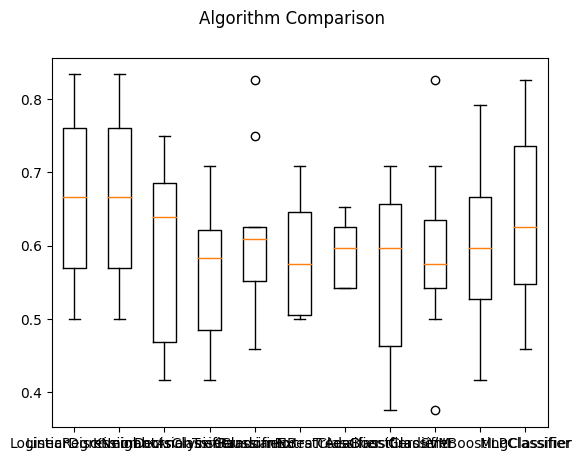

In [10]:
seed = 7
models = []

models.append(('LogisticRegression', LogisticRegression(random_state=seed)))
models.append(('LinearDiscriminantAnalysis', LinearDiscriminantAnalysis()))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier()))
models.append(('GaussianNB', GaussianNB()))
models.append(('RandomForestClassifier', RandomForestClassifier()))
models.append(('ExtraTreesClassifier',ExtraTreesClassifier(random_state=seed)))
models.append(('AdaBoostClassifier',AdaBoostClassifier(DecisionTreeClassifier(random_state=seed),random_state=seed,learning_rate=0.1)))
models.append(('SVM',svm.SVC(random_state=seed)))
models.append(('GradientBoostingClassifier',GradientBoostingClassifier(random_state=seed)))
models.append(('MLPClassifier',MLPClassifier(random_state=seed)))

# evaluate each model in turn
results = []
names = []
scoring = 'accuracy'

for name, model in models:
    kfold = KFold(n_splits=10, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X, y, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    #print(msg) 

#print(results, names)
plot_models(results, names)

# Hyper-parameter Tuning

In [11]:
param_grid={
    'n_estimators':[100,200,300],
    'max_depth':[10,20,30],
    'min_samples_split':[2,5,10],
    'min_samples_leaf':[1,2,4]
}

In [12]:
#for name, model in models:
    #grid_search = GridSearchCV(estimator = model, param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_search = GridSearchCV(estimator = RandomForestClassifier(random_state=42), param_grid = param_grid,cv = 3, n_jobs = -1, verbose = 2)
grid_search.fit(X_train, y_train)

best_params=grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")
best_model=RandomForestClassifier(**best_params, random_state=42)
best_model.fit(X_train,y_train)

Fitting 3 folds for each of 81 candidates, totalling 243 fits
Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}


RandomForestClassifier(max_depth=10, min_samples_split=10, n_estimators=200,
                       random_state=42)

# Performance Evaluation

In [13]:
y_pred=best_model.predict(X_test)
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.75      0.44      0.56        34
           1       0.63      0.87      0.73        38

    accuracy                           0.67        72
   macro avg       0.69      0.65      0.64        72
weighted avg       0.69      0.67      0.65        72



In [14]:
accuracy=accuracy_score(y_test,y_pred)
print(f"Accuracy:{accuracy}")

Accuracy:0.6666666666666666


In [15]:
df.head(5)

,EMA10,EMA30,ATR,ADX,RSI,MACD,MACD_signal,Close_EMA_10,EMA_10_EMA_30,MACD_Signal_MACD,returned,return_SPY,target
Date,,,,,,,,,,,,,
2022-11-21,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,NaN,NaN,0
2022-11-22,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,0.005737,0.013367,1
2022-11-23,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,0.016639,0.006282,1
2022-11-25,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,-0.020658,-0.000224,0
2022-11-28,NaN,NaN,0.0,0.0,NaN,NaN,NaN,-1,-1,-1,-0.015423,-0.016086,0


In [16]:
df.columns

Index(['EMA10', 'EMA30', 'ATR', 'ADX', 'RSI', 'MACD', 'MACD_signal',
       'Close_EMA_10', 'EMA_10_EMA_30', 'MACD_Signal_MACD', 'returned',
       'return_SPY', 'target'],
      dtype='object')

Plot graph to check which strategy is working

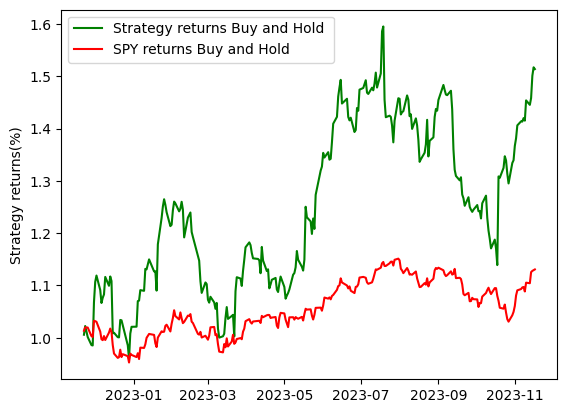

In [20]:
train_length=0
#plt.plot((df.strategy_returns[train_length:]+1).cumprod(),'b-',label='Strategy returns decision tree ')
plt.plot((df.returned[train_length:]+1).cumprod(),'g-',label='Strategy returns Buy and Hold ')
plt.plot((df['return_'+benchmark][train_length:]+1).cumprod(),'r-',label=benchmark+' returns Buy and Hold ')
plt.ylabel('Strategy returns(%)')
plt.legend()
plt.show()